In [65]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np                # Numpy for array manipulation for ease of access
import torch                      # Pytorch for array manipulation on the GPU and nice deep learning functions
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import cv2
# Image import and display libraries                       # OpenCV for image processing
import matplotlib.pyplot as plt   # Plotting functions
%matplotlib inline

# Image processing libraries for image feature extractor
from scipy.stats import kurtosis, skew
# from scipy.ndimage.filters import generic_filter
from skimage.filters import laplace, gabor
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.preprocessing import scale
from scipy.ndimage import generic_filter
# A few more tools
from sklearn import svm           # SVM classifier library
import os                         # Navigate through directories
import csv                        # Read in a CSV file
import time                       # Timing function
import pickle                     # Saving and loading variables

In [69]:
#TODO tune your own parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 10
use_gpu = False
if torch.cuda.is_available(): #use gpu if available
  use_gpu = True
  print("using cuda")

using cuda


In [71]:
import numpy as np
import os
import os.path as osp
import torch.utils.data as data
import torchvision.transforms as T
from PIL import Image

class SegSTRONGC(data.Dataset):
    def __init__(self, root_folder: str, set_indices: list, subset_indices: list, split: str = 'train', domains: list = ['regular'], image_transforms = None, gt_transforms = None):
        '''
            reference dataset loading for SegSTRONGC
            root_folder: the root_folder of the SegSTRONGC dataset
            set_indices: is the indices for sets to be used
            subset_indices: is the indices for the subsets to be used
            split: 'train', 'val' or 'test'
            domain: the image domains to be loaded.
            image_transforms: any transforms to perform, can add augmentations here.
            gt_transforms: list of bool. Indicates whether image_transforms should also be appleid to gt.
        '''
        self.split = split
        self.root_folder = root_folder
        self.set_indices = set_indices
        self.subset_indices = subset_indices
        self.domains = domains
        self.image_transforms = image_transforms
        self.gt_transforms = gt_transforms

        self.image_paths = []
        self.gt_paths = []

        for set_idx, s in enumerate(self.set_indices):
            for ss in self.subset_indices[set_idx]:
                set_folder = osp.join(self.root_folder, self.split + '/' + str(s) + '/' + str(ss))
                gt_folder = osp.join(set_folder, 'ground_truth')

                for d in self.domains:
                    image_folder = osp.join(set_folder, d)
                    for i in range(300):
                        image_name = str(i) + ".jpg"
                        gt_name = str(i) + ".png"
                        self.image_paths.append(osp.join(image_folder, 'left/' + image_name))
                        self.gt_paths.append(osp.join(gt_folder, 'left/' + gt_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image = np.array(Image.open(self.image_paths[idx])).astype(np.float32) / 255
        gt = (np.array(Image.open(self.gt_paths[idx])) / 255).astype(np.int64)
        # Apply transformation to image and ground truth
        if self.image_transforms is not None and self.gt_transforms is not None:
            image = self.image_transforms(image)
            gt = self.gt_transforms(gt)
        else:
            image = T.ToTensor()(image)
            gt = T.ToTensor()(gt)

        return image, gt

In [93]:

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    self.conv5   = add_conv_stage(256, 512, useBN=useBN)
    # Upgrade stages
    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)

    ## TODO Design your last layer & activations
    # self.conv_last = nn.Conv2d(32, 1, 1)
     #self.sigmoid = nn.Sigmoid()
    self.conv_last = nn.Sequential(
        nn.Conv2d(32, 3, 3, 1, 1),
        nn.Sigmoid())

  def forward(self, x):
    #TODO implement forward function
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))
    conv5_out = self.conv5(self.max_pool(conv4_out))

    conv5m_out = torch.cat((self.upsample54(conv5_out), conv4_out), 1)
    conv4m_out = self.conv4m(conv5m_out)
    conv4m_out_ = torch.cat((self.upsample43(conv4m_out), conv3_out), 1)
    conv3m_out = self.conv3m(conv4m_out_)
    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out = self.conv2m(conv3m_out_)
    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out = self.conv1m(conv2m_out_)
    conv0_out = self.conv_last(conv1m_out)

    return conv0_out


In [95]:
def trainning(model, trainning_dataloader, validation_dataloader, num_epochs, criterion, optimizer, filename):
    if use_gpu:
      model.cuda()
    lr_changed = False
    training_losses = []
    validation_losses = []
    total_training_loss = 0
    total_val_loss = 0
    total_training_iteration = 0
    total_val_iteration = 0
    for epoch in range(num_epochs):
        i = 0
        model.train()
        for data in trainning_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          model.zero_grad()
          loss = criterion(out, y)
          total_training_loss += loss.item()
          loss.backward()
          optimizer.step()
          i = i+1
          total_training_iteration += 1
          if total_training_iteration % 100 == 99:
            training_losses.append(total_training_loss / total_training_iteration)
        if epoch % 5 == 4:
            print("learning_rate decayed")
            for param_group in optimizer.param_groups:
              param_group['lr'] *= 0.1
        model.eval()
        for data in validation_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          model.zero_grad()
          loss = criterion(out, y)
          total_val_loss += loss.item()
          total_val_iteration += 1
          if total_val_iteration % 100 == 99:
            validation_losses.append(total_val_loss / total_val_iteration)
        print("epoch:",epoch+1,"training_loss:", total_training_loss / total_training_iteration, "validation_loss:", total_val_loss / total_val_iteration)
        torch.save(model.state_dict(), filename)
        
        # Plot training and validation losses
    plt.plot(training_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
#     plt.plot(trainning_losses)
#     plt.show()
#     plt.plot(validation_losses)
#     plt.show()

In [97]:
def DICE(model, test_dataloader, smooth=1e-10):
    dice = []
    model.eval()
    for data in test_dataloader:
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        predict = model(img) > 0.5
        num = 2 * (predict * target).sum()
        denum = predict.sum() + target.sum()
        dice.append(((num + smooth) / (denum + smooth)).item())
    m_dice = np.mean(dice)
    return m_dice


def DICELoss(scores, target):
    
    smooth = 1e-10
    num = target.size(0)  # Batch size

    # Ensure scores and target have the same number of channels
    # by squeezing the channel dimension of the target if necessary.
    # This assumes the target has a channel dimension of 1.
    if target.dim() == 4 and target.shape[1] == 1:
        target = target.squeeze(1)  # Remove channel dimension
    elif target.dim() == 3:
        # Target already has no channel dimension
        pass
    else:
        raise ValueError
    if scores.shape[1] != 1 and scores.shape[1] != target.shape[0]:
        scores = scores[:, 0, :, :] 

    m1 = scores.view(num, -1)  
    m2 = target.view(num, -1)  

    intersection = (m1 * m2).sum()

    return 1 - (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)




In [99]:
root_folder = '../DeepLearning_Fall2024_HW6/SegSTRONGC_MLDL/' #TODO replace with your own path
size = (272, 480)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_set_indices = [3, 4, 5, 7, 8]
train_subset_indices = [[0, 2], [0, 1, 2], [0, 2], [0, 1], [1, 2]]

train_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
train_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_trainning_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = train_set_indices,
    subset_indices = train_subset_indices,
    split = 'train',
    domains = ['regular'],
    image_transforms = train_image_transforms,
    gt_transforms = train_gt_transforms)
segmentation_trainning_dataloader = DataLoader(segmentation_trainning_dataset, batch_size=batch_size, shuffle=True)

val_set_indices = [1]
val_subset_indices = [[0]]

val_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
val_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_validation_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = val_set_indices,
    subset_indices = val_subset_indices,
    split = 'val',
    domains = ['regular'],
    image_transforms = val_image_transforms,
    gt_transforms = val_gt_transforms)

segmentation_validation_dataloader = DataLoader(segmentation_validation_dataset, batch_size=1, shuffle=False)

test_set_indices = [9]
test_subset_indices = [[0]]

test_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
test_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
])
segmentation_test_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = test_set_indices,
    subset_indices = test_subset_indices,
    split = 'test',
    domains = ['regular'],
    image_transforms = test_image_transforms,
    gt_transforms = test_gt_transforms)

segmentation_test_dataloader = DataLoader(segmentation_test_dataset, batch_size=1, shuffle=False)

segmentation_test_dataset_blood = SegSTRONGC(
    root_folder = root_folder,
    set_indices = test_set_indices,
    subset_indices = test_subset_indices,
    split = 'test',
    domains = ['blood'],
    image_transforms = test_image_transforms,
    gt_transforms = test_gt_transforms)

segmentation_test_dataloader_blood = DataLoader(segmentation_test_dataset_blood, batch_size=1, shuffle=False)


In [101]:
def show_demo(model, test_dataset_loader, num=10):
    model.eval()
    count = 0
    for demo in test_dataset_loader:
        demo_input, demo_target = demo
        if use_gpu:
           demo_input = demo_input.cuda()
        demo_output = model(demo_input)
        for i in range(demo_input.shape[0]):
            plt.subplot(1, 3, 1)
            plt.imshow(demo_input[i].permute(1,2,0).detach().cpu().numpy()) # Input image is fine
            plt.axis("off")
            plt.subplot(1, 3, 2)
            # The output image needs to be transposed to move the channel dimension to the last
            plt.imshow(demo_output[i].detach().cpu().numpy().squeeze().transpose(1, 2, 0)*255,cmap='gray') 
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(demo_target[i].detach().numpy().squeeze(),cmap='gray') # Target image is fine
            plt.axis("off")
            plt.show()
        if count >= num:
          break
        count += 1

epoch: 1 training_loss: 0.08610845659718369 validation_loss: 0.06119860529899597
epoch: 2 training_loss: 0.06303289686188554 validation_loss: 0.0822676972548167
epoch: 3 training_loss: 0.05313094330556465 validation_loss: 0.07830305417378744
epoch: 4 training_loss: 0.047244856664628694 validation_loss: 0.07775451049208641
learning_rate decayed
epoch: 5 training_loss: 0.04327917178471883 validation_loss: 0.07775402557849884
epoch: 6 training_loss: 0.039895215028464194 validation_loss: 0.07611119551791085
epoch: 7 training_loss: 0.037336939341062074 validation_loss: 0.0747525223663875
epoch: 8 training_loss: 0.03532407344742255 validation_loss: 0.0740779776374499
epoch: 9 training_loss: 0.03369427457803026 validation_loss: 0.07343310773372651
learning_rate decayed
epoch: 10 training_loss: 0.03231052133170041 validation_loss: 0.07348746933539708


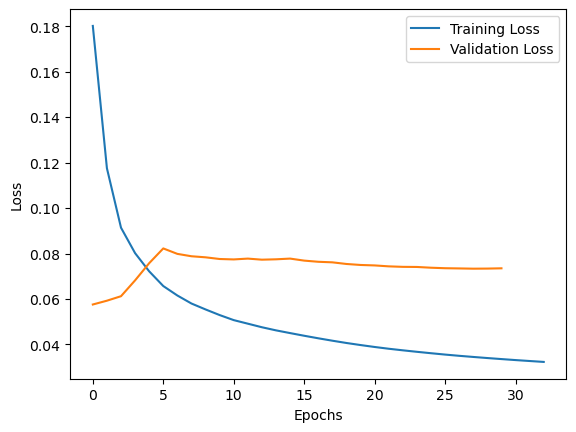

In [103]:
segmentation_model = unet(useBN=True)
dice_criterion = DICELoss
segmentation_optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainning(segmentation_model, segmentation_trainning_dataloader, segmentation_validation_dataloader,  num_epochs, dice_criterion, segmentation_optimizer, "final_vanilla_model.pth")

C:\Users\Admin\AppData\Local\Temp\ipykernel_29488\4223396084.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("final_vanilla

0.9455745706955592


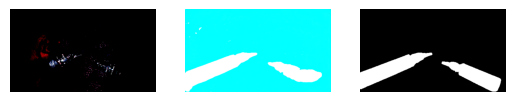

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


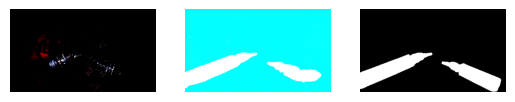

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


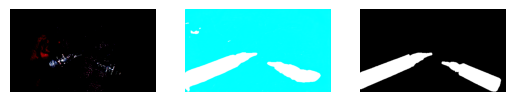

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


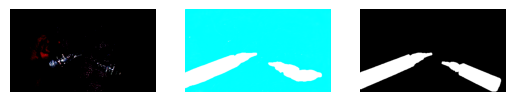

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


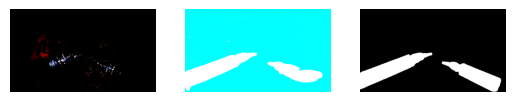

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


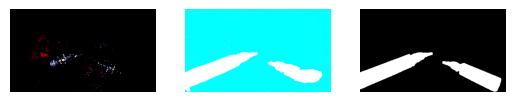

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


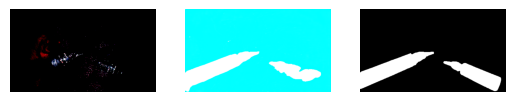

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


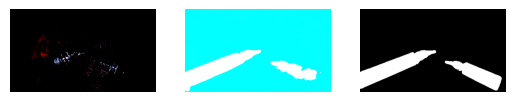

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


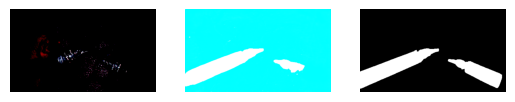

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


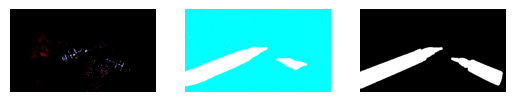

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


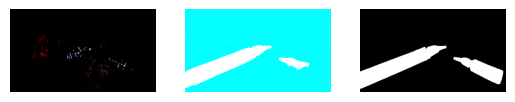

In [104]:
segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
print(DICE(segmentation_model, segmentation_test_dataloader))
show_demo(segmentation_model, segmentation_test_dataloader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_29488\1671474167.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("final_vanilla

0.45770865261554716


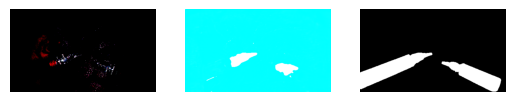

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


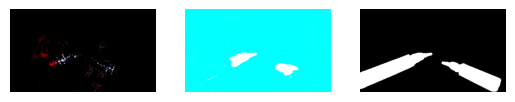

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


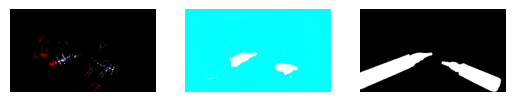

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


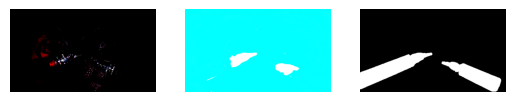

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


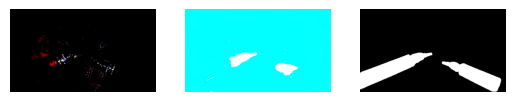

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


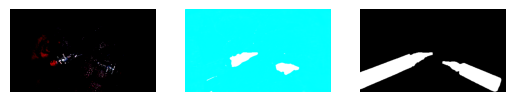

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


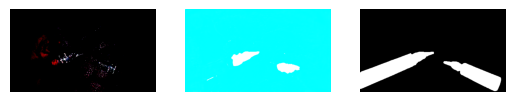

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


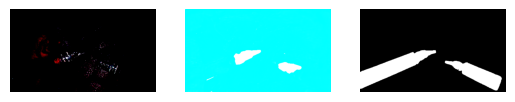

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


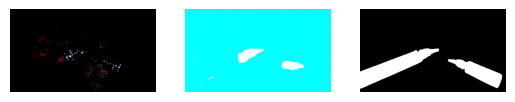

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


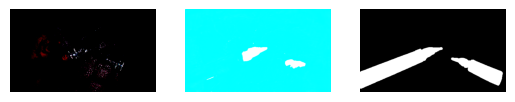

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


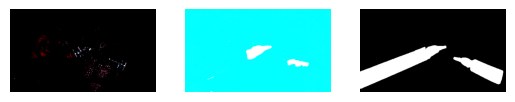

In [105]:
segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
print(DICE(segmentation_model, segmentation_test_dataloader_blood))
show_demo(segmentation_model, segmentation_test_dataloader_blood)

In [139]:
#TODO add transformations in training dataset,
# Carefully think about whether the it is suitable for segmentation task
train_image_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),                              # Convert the image to a PyTorch tensor
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST), # Resize the image to the desired size
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
    transforms.Normalize(mean=mean, std=std)])        # Normalize the image with mean and std

train_gt_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_trainning_dataset_augmented = SegSTRONGC(
    root_folder = root_folder,
    set_indices = train_set_indices,
    subset_indices = train_subset_indices,
    split = 'train',
    domains = ['regular'],
    image_transforms = train_image_transforms_augmented,
    gt_transforms = train_gt_transforms_augmented)
segmentation_trainning_dataloader_augmented = DataLoader(segmentation_trainning_dataset_augmented, batch_size=batch_size, shuffle=True)

epoch: 1 training_loss: 0.10767656474402457 validation_loss: 0.06087719639142354
epoch: 2 training_loss: 0.07990619522152526 validation_loss: 0.05539234081904094
epoch: 3 training_loss: 0.06982742325224058 validation_loss: 0.05581150737073686
epoch: 4 training_loss: 0.06331707401709123 validation_loss: 0.1086516547203064
learning_rate decayed
epoch: 5 training_loss: 0.05982061187426249 validation_loss: 0.10117597659428915
epoch: 6 training_loss: 0.05604427508031479 validation_loss: 0.09460624092155033
epoch: 7 training_loss: 0.053034025637102335 validation_loss: 0.09258232264291673
epoch: 8 training_loss: 0.05052518074711164 validation_loss: 0.08849779096742472
epoch: 9 training_loss: 0.04850048436861648 validation_loss: 0.08606008103600254
learning_rate decayed
epoch: 10 training_loss: 0.046708907466946226 validation_loss: 0.08587491079171498


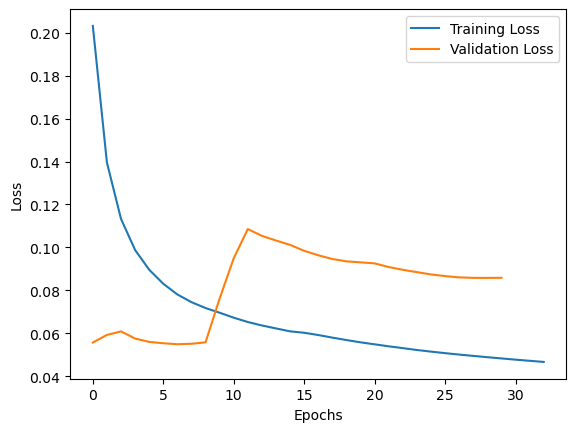

In [141]:
segmentation_model_augmented = unet(useBN=True)
dice_criterion = DICELoss
segmentation_optimizer_augmented = torch.optim.Adam(segmentation_model_augmented.parameters(), lr=learning_rate, weight_decay=1e-4)
trainning(segmentation_model_augmented, segmentation_trainning_dataloader_augmented, segmentation_validation_dataloader,  num_epochs, dice_criterion, segmentation_optimizer_augmented, "final_augmented_model.pth")

C:\Users\Admin\AppData\Local\Temp\ipykernel_29488\3140738636.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("fin

0.9485411872466405


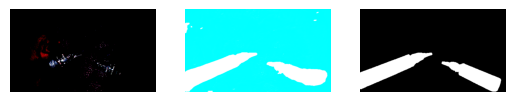

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


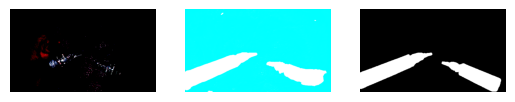

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


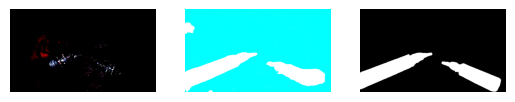

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


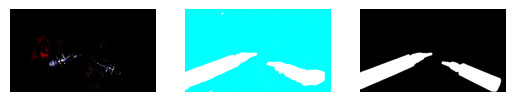

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


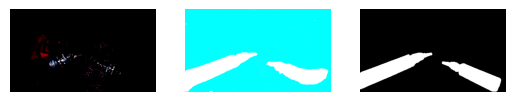

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


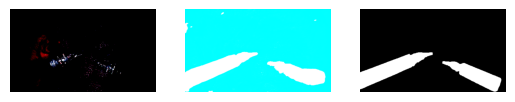

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


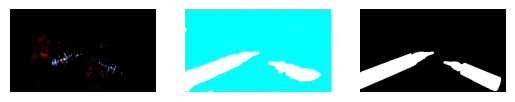

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


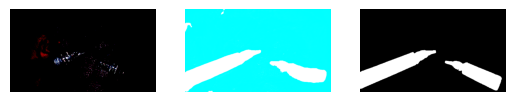

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


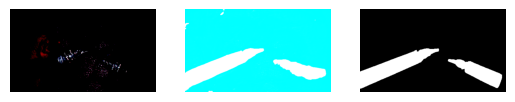

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


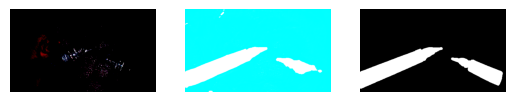

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


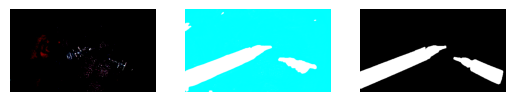

In [142]:
segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader))
show_demo(segmentation_model_augmented, segmentation_test_dataloader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_29488\3275041932.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("fin

0.6030319580435752


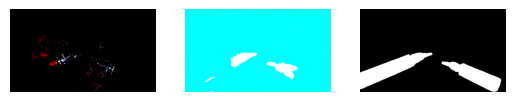

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


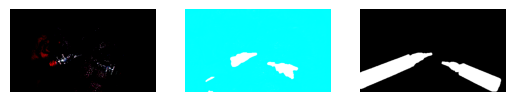

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


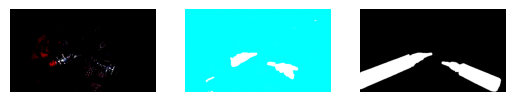

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


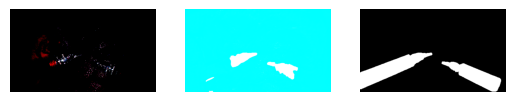

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


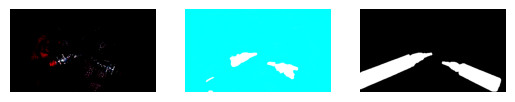

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


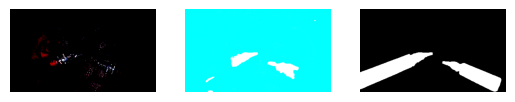

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


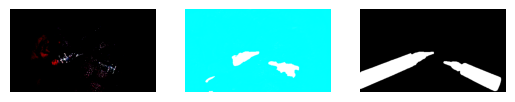

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


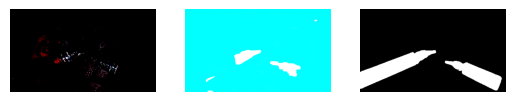

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


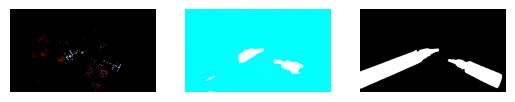

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


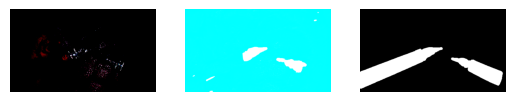

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


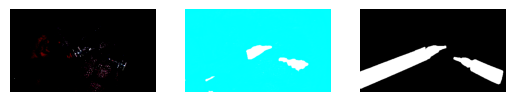

In [143]:
segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)